# CNN-LSTM

In [1]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
import datetime

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Download Datasets and Pre-Processing


In [2]:
## Load the data.
africa = pd.read_csv('C:/Users/admin/Desktop/AI/FINAL/southafrica.csv', parse_dates=['date'])

date = africa.iloc[:,0]
cases = africa.iloc[:,2]
daily_cases = africa.iloc[:,2]

#[橫:直]

In [3]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):     #生成訓練資料集的序列（sequence）資料
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 監督學習數據的數據轉換
seq_length = 5
X, y = create_sequences(daily_cases, seq_length)

# 將數據集分為訓練集、驗證集和測試集。
train_size = int(327 * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

MIN = X_train.min()
MAX = X_train.max()

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

# 最大最小值縮放
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

# 張量變換
def make_Tensor(array):
    return torch.from_numpy(array).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)



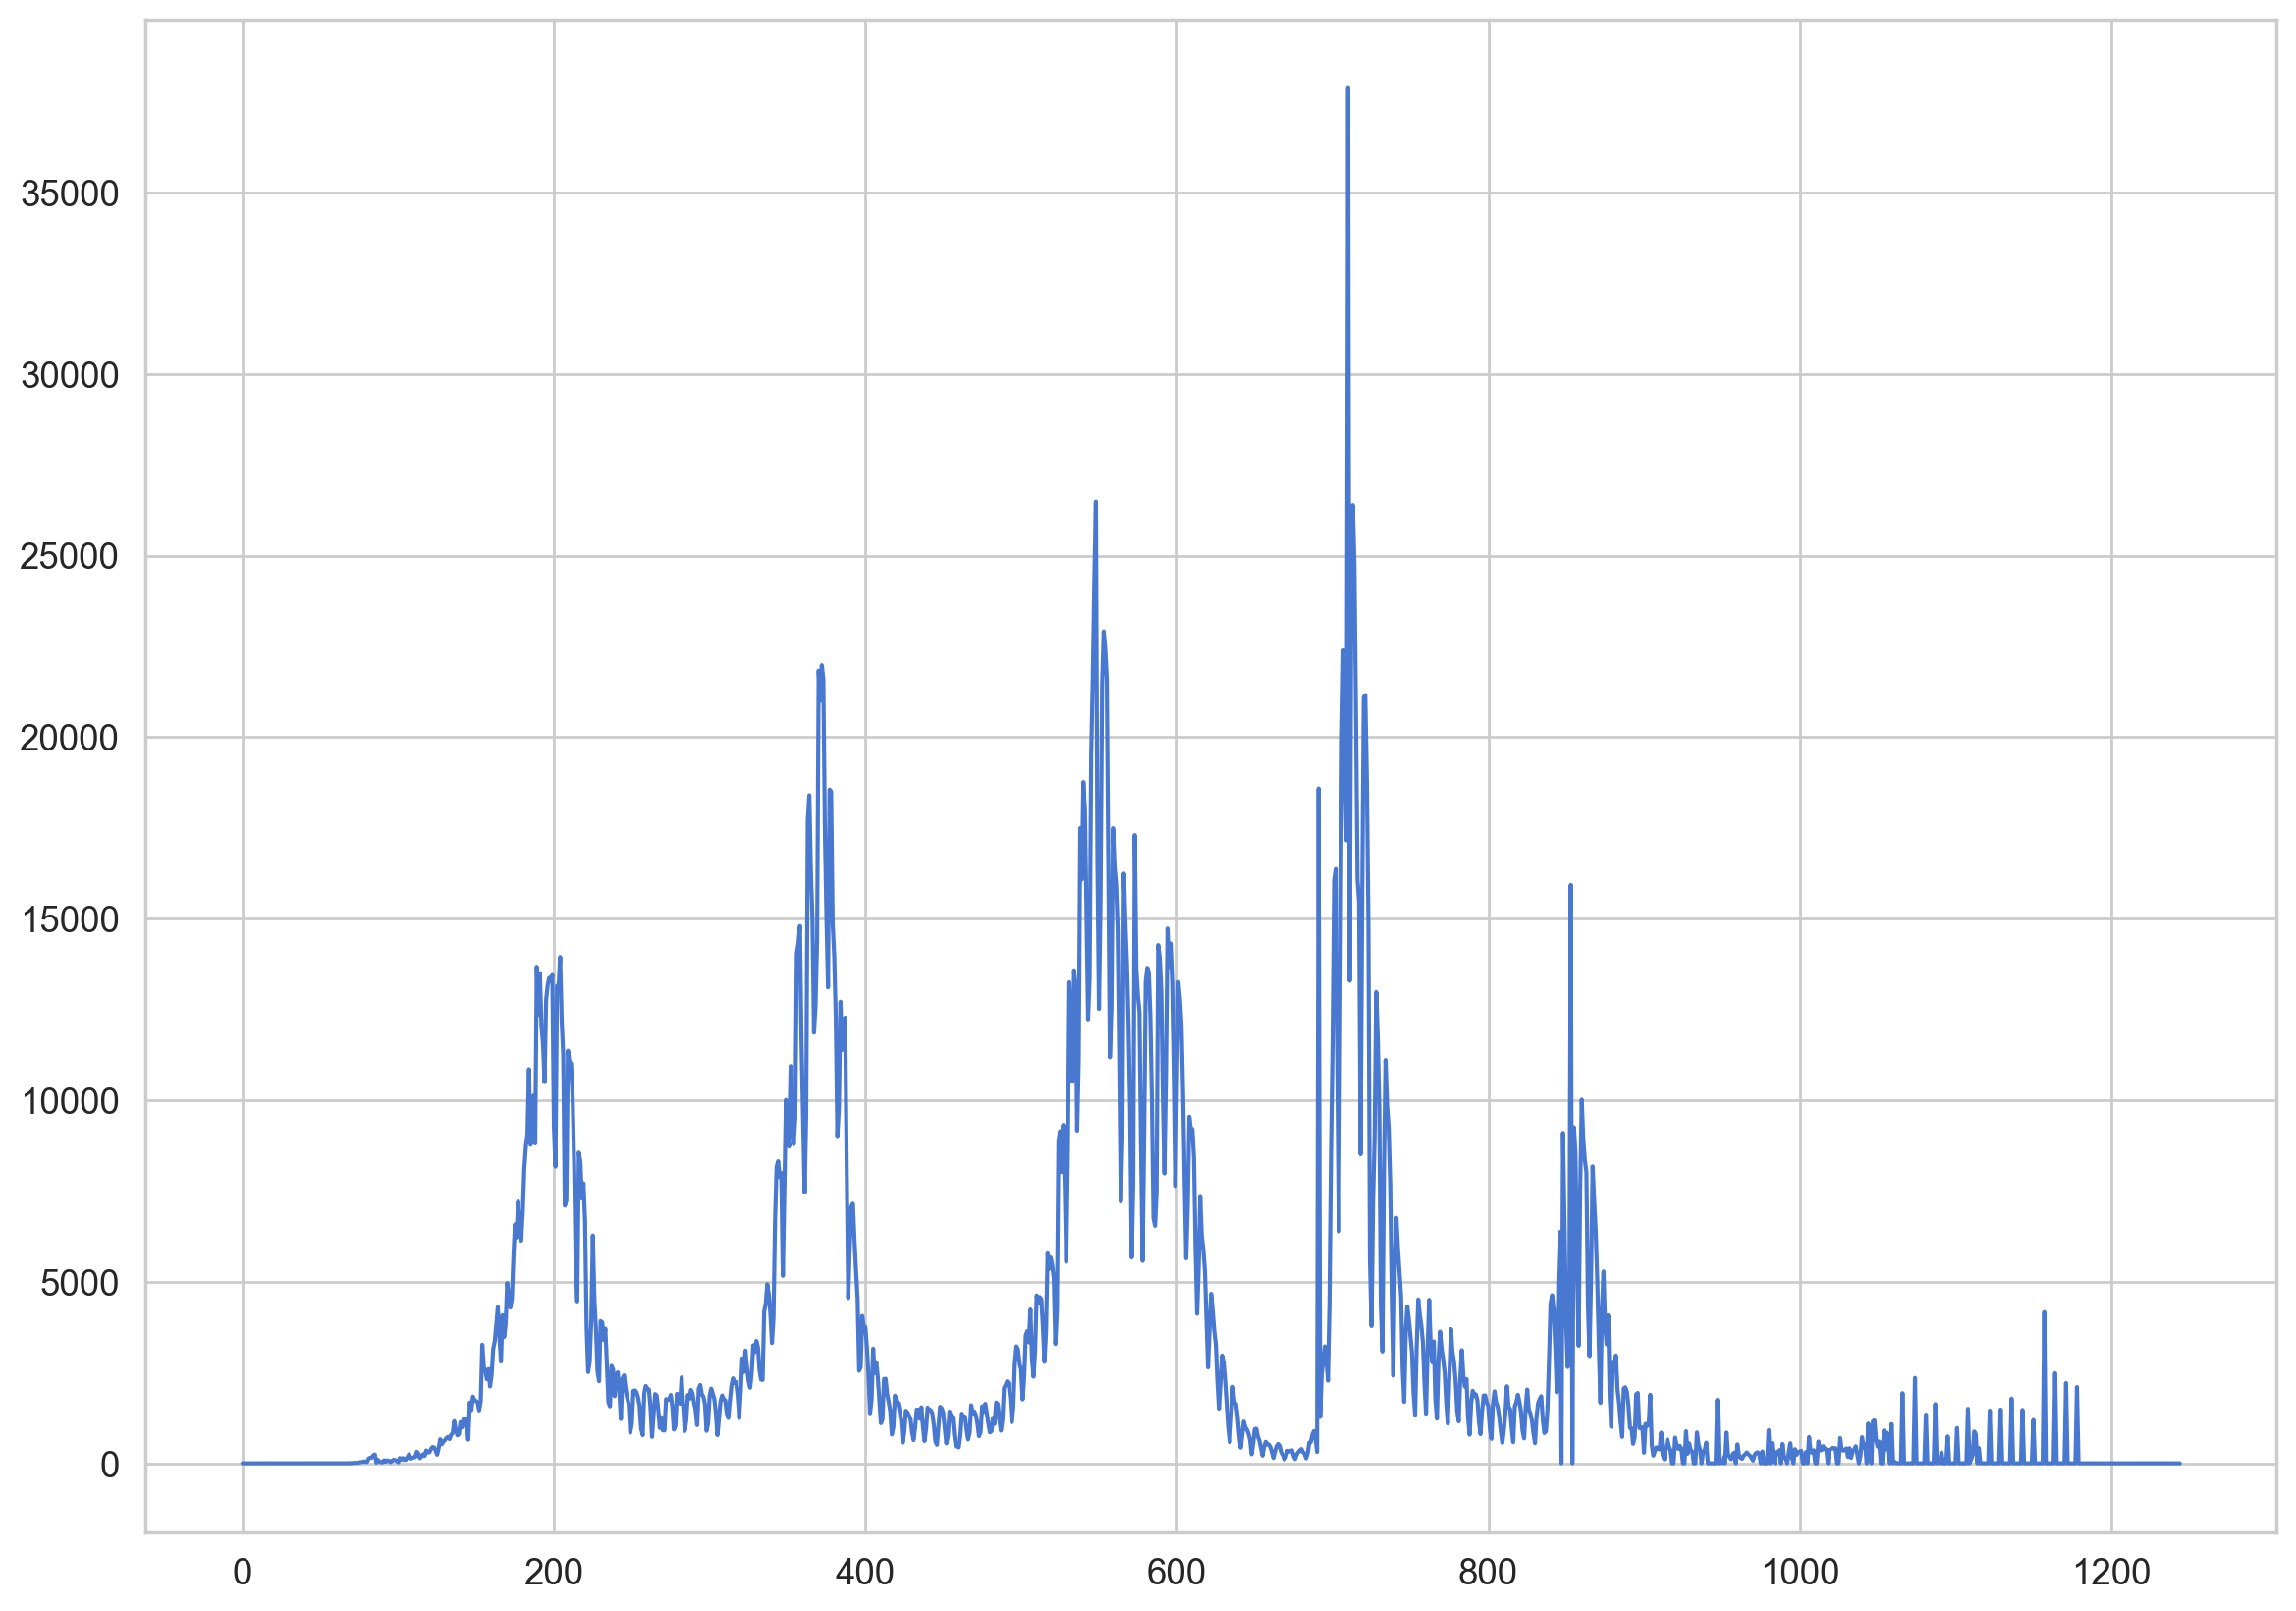

In [4]:
plt.plot(daily_cases.values)

In [5]:
# 卷基層進行一維卷積
c = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1)
input = torch.Tensor([[[1,2,3,4,5]]])
output = c(input)
output

tensor([[[1.5488, 2.6763, 3.8038, 4.9313]]], grad_fn=<ConvolutionBackward0>)

In [6]:
#保存在c中的權重和偏差的值
for param in c.parameters():
    print(param)

Parameter containing:
tensor([[[0.5406, 0.5869]]], requires_grad=True)
Parameter containing:
tensor([-0.1657], requires_grad=True)


In [7]:
#因為kernal_size=2，所以有兩個權重，保存在w1、w2，b是bias value
w_list = []
for param in c.parameters():
    w_list.append(param)

w = w_list[0]
b = w_list[1]

w1 = w[0][0][0]
w2 = w[0][0][1]

print(w1)
print(w2)
print(b)

tensor(0.5406, grad_fn=<SelectBackward0>)
tensor(0.5869, grad_fn=<SelectBackward0>)
Parameter containing:
tensor([-0.1657], requires_grad=True)


In [8]:
w1 * 3 + w2 * 4 + b

tensor([3.8038], grad_fn=<AddBackward0>)

In [9]:
output

tensor([[[1.5488, 2.6763, 3.8038, 4.9313]]], grad_fn=<ConvolutionBackward0>)

In [10]:
#CNN-LSTM模型
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size = 2, stride = 1) # 一個一維的CNN
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)  #線性層
    def reset_hidden_state(self):   #用來重製隱藏狀態
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden)
        )
    def forward(self, sequences):  #通過一維卷積之後經過LSTM處理並輸出
        sequences = self.c1(sequences.view(len(sequences), 1, -1))
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len-1, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [11]:
#建立訓練模型的函數
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): #每次採樣完隱藏層都需要重置

            model.reset_hidden_state()

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) #計算loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # 每次採樣完隱藏層都需要重製

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) 

            #印出loss
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            #防止過度擬合
            if (t % patience == 0) & (t != 0):
                
                ## 如果loss增加，提早停止
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

  


In [12]:
model = CovidPredictor(
    n_features=1,
    n_hidden=2,
    seq_len=seq_length,
    n_layers=1
)

In [13]:
print(model)

CovidPredictor(
  (c1): Conv1d(1, 1, kernel_size=(2,), stride=(1,))
  (lstm): LSTM(1, 2)
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [14]:
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

c:\ProgramData\Anaconda3\envs\AI_class\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 0 train loss: 0.2597642729051725 val loss: 0.10916362702846527
Epoch 10 train loss: 0.04357458596582564 val loss: 0.030636468902230263
Epoch 20 train loss: 0.043310591742267895 val loss: 0.029396047815680504
Epoch 30 train loss: 0.042963124582721494 val loss: 0.028790492564439774
Epoch 40 train loss: 0.04294797411399012 val loss: 0.02814185805618763
Epoch 50 train loss: 0.042235575935163736 val loss: 0.02781602367758751
Epoch 60 train loss: 0.04159260084660781 val loss: 0.027412092313170433
Epoch 70 train loss: 0.040877298361860874 val loss: 0.026351911947131157
Epoch 80 train loss: 0.0398987309788211 val loss: 0.026545515283942223
Epoch 90 train loss: 0.03953011308540679 val loss: 0.024778306484222412


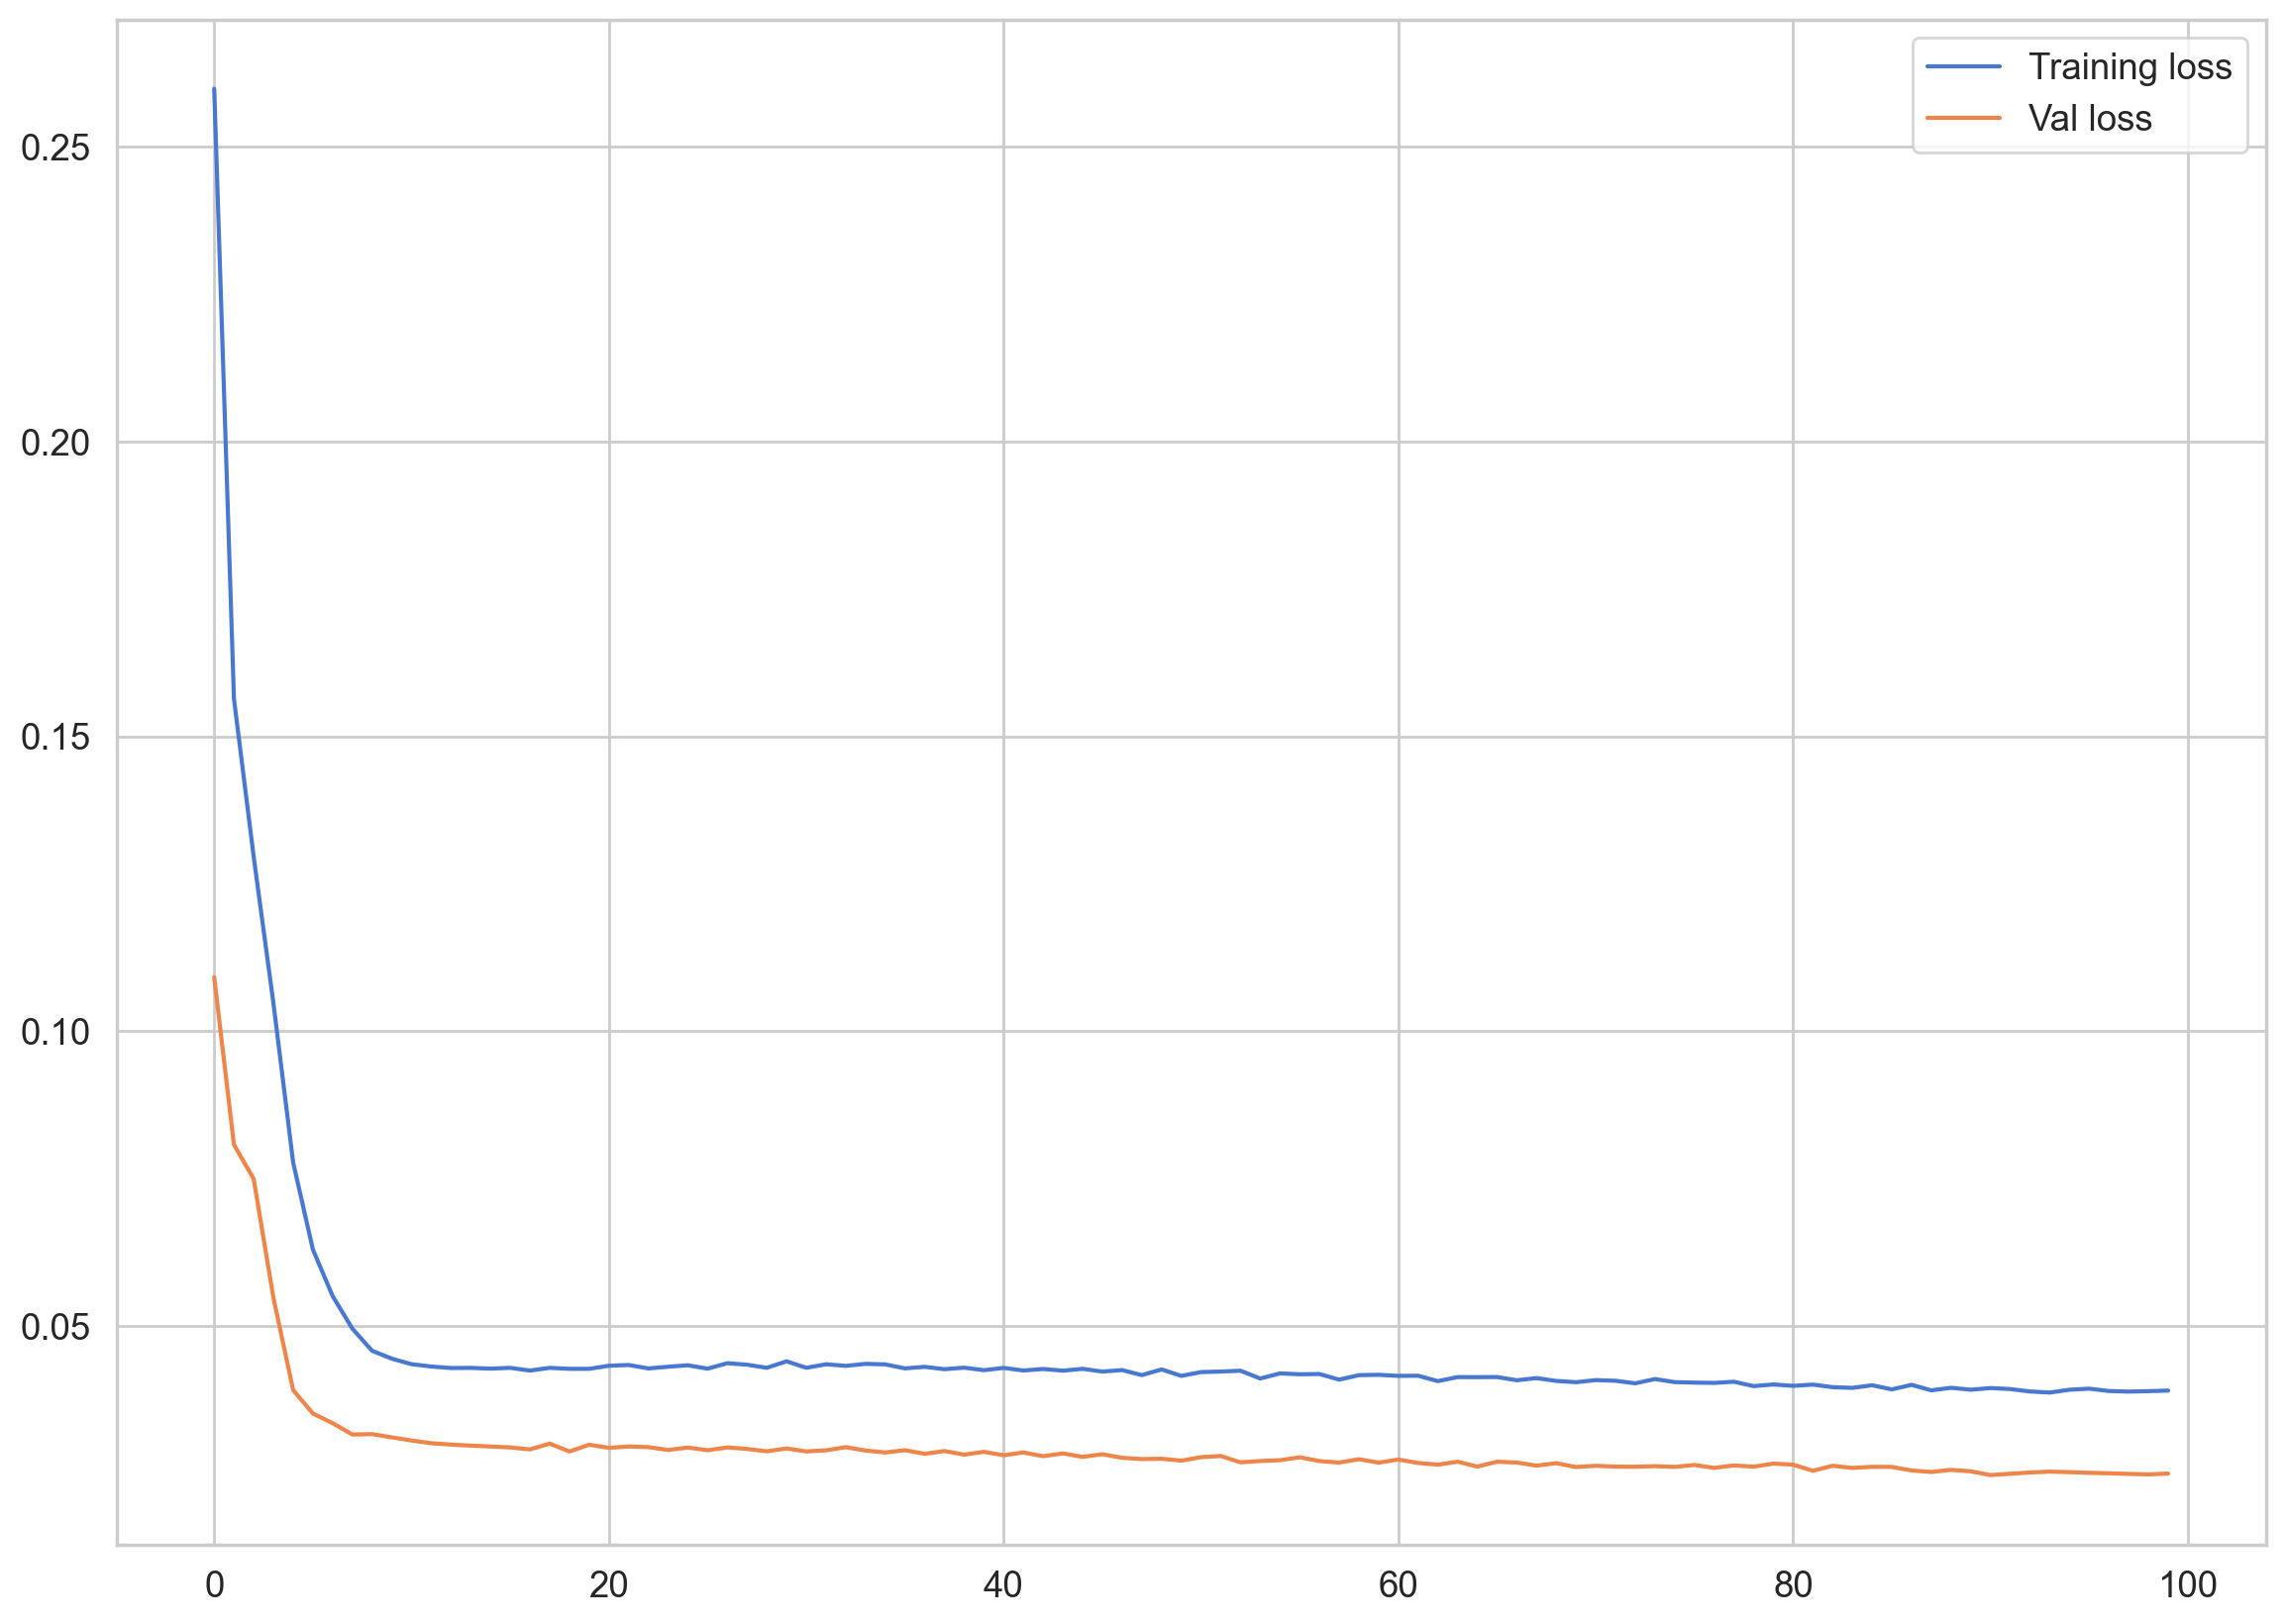

In [15]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

In [16]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

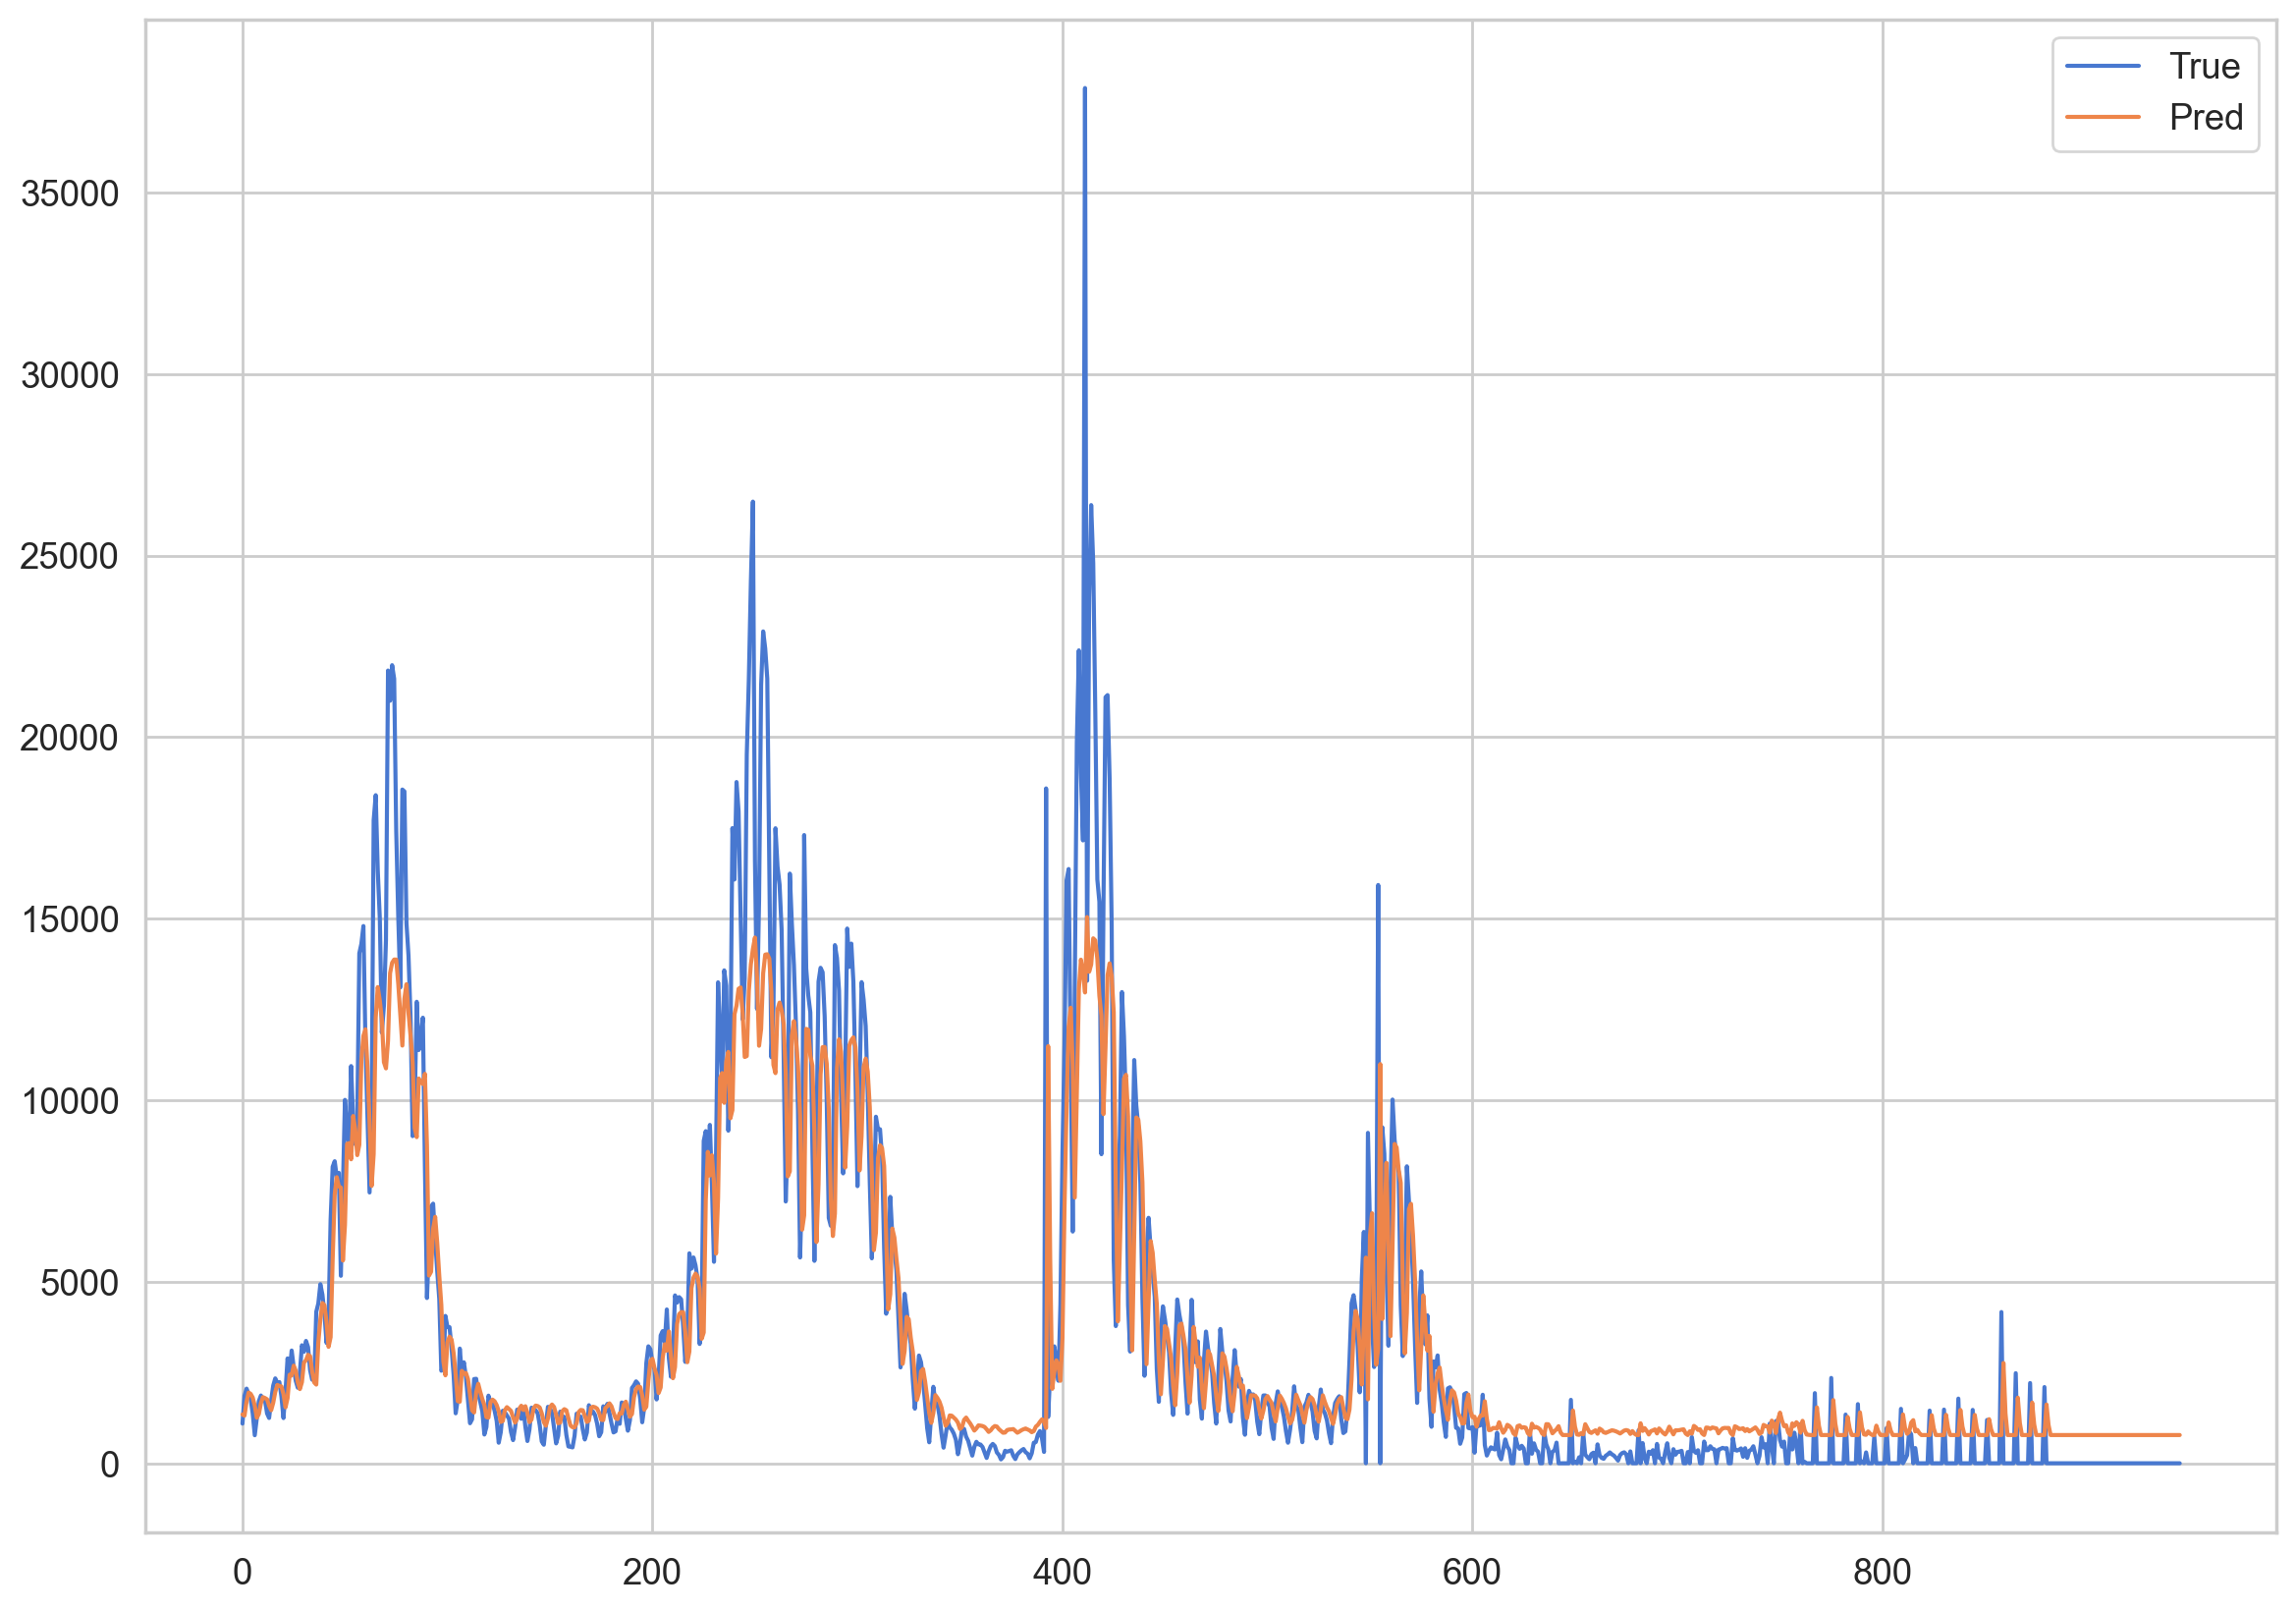

In [17]:
plt.plot(np.array(y_test)*MAX, label = 'True')
plt.plot(np.array(preds)*MAX, label = 'Pred')
plt.legend()

In [18]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [19]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)  #平均絕對誤差，確保所有誤差都是在同樣的標準下計算

1309.9023976749395

與真實誤差相當大